In [0]:
from __future__ import absolute_import, division, print_function

!pip install -q tensorflow==2.0.0-alpha0
!pip install pynrrd

import tensorflow as tf
import numpy as np
import pandas as pd
import os
import random
import math
import pickle
import nibabel as nib

from tensorflow import keras
from tensorflow.keras import datasets, layers, models

from skimage.transform import resize
from numpy.random import choice

import nrrd
import time

In [0]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount = True)

Mounted at /content/gdrive


In [0]:
# Source : https://stackoverflow.com/questions/9770668/scramble-python-list

def scrambled(orig):
    dest = orig[:]
    random.seed(567)
    random.shuffle(dest)
    return dest

In [0]:
path = 'practicum/brats/HGG/'
surv_csv = pd.read_csv("practicum/brats/survival_data.csv")
copy = surv_csv['BraTS18ID'].copy()
filenames = scrambled(copy)
#filenames = scrambled(surv_csv['BraTS18ID'])
#filenames = os.listdir(path)


In [0]:
surv_csv.loc[surv_csv['BraTS18ID'] == 'Brats18_TCIA03_338_1']

,BraTS18ID,Age,Survival,ResectionStatus
31,Brats18_TCIA03_338_1,76.425,468,NaN


In [0]:
for i in range(3):
  print(filenames[i])

Brats18_TCIA01_425_1
Brats18_CBICA_AOP_1
Brats18_TCIA06_372_1


In [0]:
data = []

for index,i in enumerate(filenames):
#  print(i)
  temp = path + i + "/" + i + "_t1.nii.gz"
  scan = nib.load(temp)
  os = surv_csv.loc[surv_csv['BraTS18ID'] == i]['Survival'].values[0]
  print("Temp is " + str(i) + " and os is " + str(os))
  print(surv_csv.loc[surv_csv['BraTS18ID'] == i])
  data.append([np.array(scan.dataobj),os])

Temp is Brats18_TCIA01_425_1 and os is 558
               BraTS18ID     Age  Survival ResectionStatus
75  Brats18_TCIA01_425_1  56.208       558             NaN
Temp is Brats18_CBICA_AOP_1 and os is 332
               BraTS18ID     Age  Survival ResectionStatus
140  Brats18_CBICA_AOP_1  67.833       332             GTR
Temp is Brats18_TCIA06_372_1 and os is 213
               BraTS18ID     Age  Survival ResectionStatus
10  Brats18_TCIA06_372_1  74.521       213             NaN
Temp is Brats18_TCIA02_274_1 and os is 357
               BraTS18ID     Age  Survival ResectionStatus
35  Brats18_TCIA02_274_1  54.967       357             NaN
Temp is Brats18_TCIA01_235_1 and os is 804
               BraTS18ID     Age  Survival ResectionStatus
63  Brats18_TCIA01_235_1  57.973       804             NaN
Temp is Brats18_CBICA_AAB_1 and os is 289
               BraTS18ID     Age  Survival ResectionStatus
162  Brats18_CBICA_AAB_1  60.463       289             GTR
Temp is Brats18_CBICA_AWH_1 and os i

In [0]:
blah = "Brats18_CBICA_ABY_1"
surv_csv.loc[surv_csv['BraTS18ID'] == blah]

,BraTS18ID,Age,Survival,ResectionStatus
153,Brats18_CBICA_ABY_1,48.367,515,GTR


In [0]:
for i in range(3):
  print(data[i][1])

558
332
213


In [0]:
x_train = []
y_train = []

for i,j in data:
  x_train.append(i)
  y_train.append(j)

In [0]:
l_max_i = []
l_min_i = []
l_max_j = []
l_min_j = []
l_max_k = []
l_min_k = []

for index,i in enumerate(x_train):
  zi = np.argwhere(i)
  max_i = np.max([zi[:,0]])
  min_i = np.min([zi[:,0]])
  max_j = np.max([zi[:,1]])
  min_j = np.min([zi[:,1]])
  max_k = np.max([zi[:,2]])
  min_k = np.min([zi[:,2]])
  
  l_max_i.append(max_i)
  l_min_i.append(min_i)
  l_max_j.append(max_j)
  l_min_j.append(min_j)
  l_max_k.append(max_k)
  l_min_k.append(min_k)

In [0]:
avg_i_high = np.around(np.mean(l_max_i)).astype(int)
avg_i_low = np.around(np.mean(l_min_i)).astype(int)
avg_j_high = np.around(np.mean(l_max_j)).astype(int)
avg_j_low = np.around(np.mean(l_min_j)).astype(int)
avg_k_high = np.around(np.mean(l_max_k)).astype(int)
avg_k_low = np.around(np.mean(l_min_k)).astype(int)

In [0]:
cut = 20
for index,vol in enumerate(x_train):
  x_train[index] = x_train[index][avg_i_low + cut : avg_i_high - cut, avg_j_low + cut : avg_j_high - cut, avg_k_low + cut : avg_k_high - cut]

In [0]:
for index,vol in enumerate(x_train):
  mean = np.mean(x_train[index])
  std = np.std(x_train[index])
  x_train[index] = (x_train[index] - mean)/std

In [0]:
x_train = np.array(x_train)
y_train = np.array(y_train)

In [0]:
np.shape(x_train[5])

(96, 128, 97)

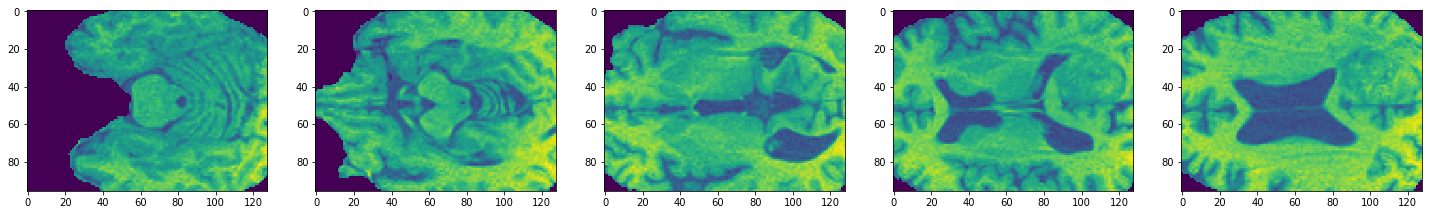

In [0]:
import matplotlib.pyplot as plt
f,ax = plt.subplots(1,5, figsize = (25,25))
sls = [30,40,50,60,70]
for i,j in enumerate(sls):
    ax[i].imshow(x_train[25][:,:,j])
plt.show()

In [0]:
x_train = np.expand_dims(x_train, axis = -1)

In [0]:
cuts = np.percentile(y_train, [33,66,100])
cuts

array([ 241.3,  452.6, 1767. ])

In [0]:
# Note : Don't run this twice in a single session
# Minus 1 is to zero index

#bins = np.array([0, 12, 24, 36, 48, 60, 72, 84, 135])
bins = np.array([0,241,453,2000])
y_train = np.digitize(y_train, bins) - 1

In [0]:
y_train

array([2, 1, 0, 1, 2, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 2, 2, 0, 1, 2, 0,
       0, 1, 1, 0, 2, 0, 2, 2, 2, 2, 2, 0, 2, 2, 1, 2, 2, 1, 2, 1, 0, 0,
       0, 1, 0, 2, 1, 0, 2, 2, 2, 1, 1, 2, 1, 1, 2, 0, 0, 0, 2, 2, 1, 0,
       0, 2, 0, 0, 2, 0, 1, 1, 2, 2, 2, 0, 1, 1, 1, 0, 2, 0, 1, 0, 1, 2,
       0, 2, 0, 2, 2, 0, 0, 1, 2, 0, 0, 0, 1, 1, 0, 2, 2, 0, 0, 2, 1, 1,
       1, 2, 2, 2, 1, 1, 1, 2, 1, 1, 1, 0, 2, 1, 1, 1, 2, 0, 2, 1, 1, 2,
       1, 0, 2, 1, 1, 0, 2, 1, 1, 2, 0, 0, 0, 1, 2, 2, 2, 0, 1, 0, 2, 0,
       0, 2, 2, 1, 0, 1, 2, 1, 0])

In [0]:
np.unique(y_train, return_counts = True)

(array([0, 1, 2]), array([54, 53, 56]))

In [0]:
#Define model architecture

model = models.Sequential()

model.add(layers.Conv3D(32, kernel_size = (3, 3, 3), activation = 'selu', input_shape = (96,128,97, 1), kernel_regularizer = keras.regularizers.l2(0.1)))
model.add(layers.BatchNormalization())

model.add(layers.MaxPooling3D((2, 2, 2)))

model.add(layers.Conv3D(32, kernel_size = (3, 3, 3), activation='selu', kernel_regularizer = keras.regularizers.l2(0.1)))
model.add(layers.BatchNormalization())

#additional
#model.add(layers.MaxPooling3D((2, 2, 2)))

model.add(layers.Conv3D(32, kernel_size = (3, 3, 3), activation='selu', kernel_regularizer = keras.regularizers.l2(0.1)))
model.add(layers.BatchNormalization())

model.add(layers.MaxPooling3D((2, 2, 2)))

model.add(layers.Conv3D(32, kernel_size = (3, 3, 3), activation='selu', kernel_regularizer = keras.regularizers.l2(0.1)))
model.add(layers.BatchNormalization())

model.add(layers.MaxPooling3D((2, 2, 2)))

model.add(layers.Conv3D(32, kernel_size = (3, 3, 3), strides = 2, activation='selu', kernel_regularizer = keras.regularizers.l2(0.1)))
model.add(layers.MaxPooling3D((2, 2, 2)))

model.add(layers.Flatten())

model.add(layers.Dense(20, activation = 'selu', kernel_regularizer = keras.regularizers.l2(0.1)))
model.add(layers.Dense(10, activation = 'selu', kernel_regularizer = keras.regularizers.l2(0.1)))
model.add(layers.Dense(3, activation = 'softmax', kernel_regularizer = keras.regularizers.l2(0.1)))

In [0]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d (Conv3D)              (None, 94, 126, 95, 32)   896       
_________________________________________________________________
batch_normalization_v2 (Batc (None, 94, 126, 95, 32)   128       
_________________________________________________________________
max_pooling3d (MaxPooling3D) (None, 47, 63, 47, 32)    0         
_________________________________________________________________
conv3d_1 (Conv3D)            (None, 45, 61, 45, 32)    27680     
_________________________________________________________________
batch_normalization_v2_1 (Ba (None, 45, 61, 45, 32)    128       
_________________________________________________________________
conv3d_2 (Conv3D)            (None, 43, 59, 43, 32)    27680     
_________________________________________________________________
batch_normalization_v2_2 (Ba (None, 43, 59, 43, 32)    1

In [0]:
model.compile(optimizer= keras.optimizers.Adam(learning_rate = 0.0005),
              loss='sparse_categorical_crossentropy',
              metrics = ['acc'])

In [0]:
model.evaluate(x_train[-17:], y_train[-17:], batch_size = 7)

17/17 [==============================] - 29s 2s/sample - loss: 19.8972 - acc: 0.2353


[19.89719794778263, 0.23529412]

In [0]:
history = model.fit(x_train,y_train, batch_size=7, epochs = 100, validation_split = 0.1,\
          callbacks = [keras.callbacks.EarlyStopping(monitor = 'val_acc', patience=12, restore_best_weights = True)])

Train on 146 samples, validate on 17 samples
Epoch 1/100
146/146 [==============================] - 1412s 10s/sample - loss: 19.8459 - acc: 0.3014 - val_loss: 19.3898 - val_acc: 0.2941
Epoch 2/100
146/146 [==============================] - 1379s 9s/sample - loss: 18.8840 - acc: 0.3151 - val_loss: 18.6335 - val_acc: 0.2941
Epoch 3/100
146/146 [==============================] - 1380s 9s/sample - loss: 17.9851 - acc: 0.5753 - val_loss: 17.9089 - val_acc: 0.2941
Epoch 4/100
146/146 [==============================] - 1380s 9s/sample - loss: 17.2208 - acc: 0.4863 - val_loss: 17.3489 - val_acc: 0.2353
Epoch 5/100
146/146 [==============================] - 1383s 9s/sample - loss: 16.3273 - acc: 0.5959 - val_loss: 16.7281 - val_acc: 0.2941
Epoch 6/100
146/146 [==============================] - 1392s 10s/sample - loss: 15.4243 - acc: 0.7397 - val_loss: 15.7300 - val_acc: 0.3529
Epoch 7/100
146/146 [==============================] - 1393s 10s/sample - loss: 14.5989 - acc: 0.7808 - val_loss: 14.97

In [0]:
import matplotlib.pyplot as plt

#visualizing losses and accuracy

train_loss = history.history['loss']
validation_loss = history.history['val_loss']
train_acc  = history.history['acc']
validation_acc  = history.history['val_acc']

In [0]:
plt.figure()
plt.plot( train_loss,label='training loss')
plt.plot( validation_loss,label='validation loss')
plt.title('Train and validation loss')
plt.legend()



In [0]:
plt.figure()
plt.plot( train_loss,label='training loss')
plt.plot( validation_loss,label='validation loss')
plt.title('Train and validation loss')
plt.legend()

